In [7]:
pip install yfinance

In [105]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import re
import pprint
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import seaborn as sns

# Nerdwallet
https://www.nerdwallet.com/blog/mortgages/current-interest-rates/

In [9]:
req = requests.get("https://www.nerdwallet.com/blog/mortgages/current-interest-rates/")
bs = BeautifulSoup(req.content,'lxml')
#bs = bs.prettify()
search = bs.find_all('td')

int_rates = pd.DataFrame()
dates = []
year_30 = []
year_15 = []
apr = []
count = 0

for i in search[:1544]:
  if i.get('class')[0] == 'column-1':
    dates.append(i.text)
    continue
  if i.get('class')[0] == 'column-2':
    year_30.append(i.text)
    continue
  if i.get('class')[0] == 'column-3':
    year_15.append(i.text)
    continue
  if i.get('class')[0] == 'column-4':
    apr.append(i.text)
    continue

int_rates['Date'] = dates
int_rates['Date'] = int_rates['Date'].apply(lambda x: pd.to_datetime(x))
int_rates['30-year rate'] = year_30
int_rates['30-year rate'] = int_rates['30-year rate'].str.extract('(\d\D\d\d)')
int_rates['30-year rate'] = int_rates['30-year rate'].apply(float)
int_rates['15-year rate'] = year_15
int_rates['15-year rate'] = int_rates['15-year rate'].str.extract('(\d\D\d\d)')
int_rates['15-year rate'] = int_rates['15-year rate'].apply(float)
int_rates['APR'] = apr
int_rates['APR'] = int_rates['APR'].str.extract('(\d\D\d\d)')
int_rates['APR'] = int_rates['APR'].apply(float)
int_rates.index = int_rates['Date']
int_rates.head(10)
#search

,Date,30-year rate,15-year rate,APR
Date,,,,
2021-02-17,2021-02-17,2.85,2.29,2.93
2021-02-16,2021-02-16,2.85,2.25,2.94
2021-02-12,2021-02-12,2.74,2.28,2.91
2021-02-11,2021-02-11,2.90,2.42,3.06
2021-02-10,2021-02-10,2.77,2.25,2.94
2021-02-09,2021-02-09,2.73,2.30,2.91
2021-02-08,2021-02-08,2.79,2.36,2.97
2021-02-05,2021-02-05,2.80,2.26,2.96
2021-02-04,2021-02-04,2.86,2.39,3.08


# Yahoo finance

In [10]:
req = requests.get("https://finance.yahoo.com/")
bs = BeautifulSoup(req.content)
search = bs.find_all('script')
script = bs.find("script",text=re.compile("root.App.main")).text

https://stackoverflow.com/questions/39631386/how-to-understand-this-raw-html-of-yahoo-finance-when-retrieving-data-using-pyt

In [11]:
def extract_index_price(ind):
  #Extracting 10000 characters after following the 'quoteData' string which captures the prices for all the indexes
  quotes = script[script.find('quoteData'):script.find('quoteData')+20000]

  #Extracting index price
  price = quotes[quotes.find(ind):quotes.find(ind)+8000]
  current = price[price.find('regularMarketPrice'):price.find('regularMarketPrice')+500]
  prev = price[price.find('regularMarketPreviousClose'):price.find('regularMarketPreviousClose')+500]
  change_per = price[price.find('regularMarketChangePercent'):price.find('regularMarketChangePercent')+500]
  change = price[price.find('regularMarketChange'):price.find('regularMarketChange')+500]
  current = re.findall('"raw":\d+\D\d+',current)[0][6:]
  prev = re.findall('"raw":\d+\D\d+',prev)[0][6:]
  change_per = re.findall('"raw":\d+\D\d+',change_per)[0][6:]
  change = re.findall('"raw":\D*\d+\D*\d*',change)[0][6:]
  return (current,prev,change,change_per)

In [147]:
index_futures = ['S&P Futures','Dow Futures','Nasdaq Futures','Russell 2000 Futures','Crude Oil','10-Yr Bond','FTSE 100']
index = ['S&P 500','Dow 30','Nasdaq','Russell 2000','Crude Oil','10-Yr Bond','FTSE 100']

others = ['Gold','Silver','EUR/USD','Nikkei 225','GBP/USE']
price_type = ['regularMarketPrice','regularMarketPreviousClose']
value_curr = []
value_prev = []
value_ch_percent = []
value_ch = []
count = 0

for i in index:
  count = count + 1
  print (count)
  price_curr,price_prev,price_change,price_change_percent = extract_index_price(i)
  value_curr.append(price_curr)
  value_prev.append(price_prev)
  value_ch_percent.append(price_change_percent)
  value_ch.append(price_change)

indexes = pd.DataFrame()
indexes['Index'] = index
indexes['Current'] = value_curr
indexes['Current'] = indexes['Current'].apply(float)
indexes['Prev Close'] = value_prev
indexes['Prev Close'] = indexes['Prev Close'].apply(float)
indexes['Change'] = value_ch
indexes['Change'] = indexes['Change'].apply(float).apply(float)
indexes['Change Percent'] = value_ch_percent
indexes['Change Percent'] = indexes['Change Percent'].apply(float)
indexes.index = indexes['Index']

1
2
3
4
5
6
7

S&P 500 : 3931.33
Dow 30 : 31613.02
Nasdaq : 13965.495
Russell 2000 : 2256.1057
Crude Oil : 61.72
10-Yr Bond : 1.301
FTSE 100 : 6710.9


# Covid vaccinations - New York Times

https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html

In [56]:
req = requests.get("https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html")
bs = BeautifulSoup(req.content)
search = bs.find_all('td')

vac_labels = {'Atleast one shot':'g-cell-color','Two shots':'g-border-r','Total doses shipped':'distributed','Total shots given':'g-hide-mobile',
              'Doses used':'g-sm'}

atl_one_shot = 0
two_shots = 0
doses_del = 0
shots_given = 0
doses_used = 0

for i in search: 
  cls = i.get('class')
  #distributed is the last word in the list for all <td> tags for vaccine table
  if cls[-1] == 'g-cell-color':
    atl_one_shot = i.text
  if cls[-1] == 'g-border-r':
    two_shots = i.text
  if cls[-1] == 'distributed':
    doses_del = i.text
  if cls[-1] == 'g-hide-mobile':
    shots_given = i.text
  if cls[-1] == 'g-sm':
    doses_used = i.text
    break
    
vac_values = [atl_one_shot,two_shots,doses_del,shots_given,doses_used]
vac_values = list(map(str.strip,vac_values))

print ("At least 1 shot given: ",atl_one_shot)
print ("Two shots given: ",two_shots)
print ("Total doses delivered: ",doses_del)
print("Total shots given: ",shots_given)
print("Doses used: ",doses_used)

At least 1 shot given:  
12%

Two shots given:  
4.7%

Total doses delivered:  
72,423,125

Total shots given:  
56,281,827

Doses used:  
78%



# Covid cases - Worldometer

In [57]:
req = requests.get("https://www.worldometers.info/coronavirus/country/us/")
bs = BeautifulSoup(req.content)

div = bs.find_all('div')
cov_data = []

for i in div:
  if i.get('id') == "maincounter-wrap":
    cov_data.append(i)

In [58]:
cases = cov_data[0].find('h1')
cases = cases.text
cases_val = cov_data[0].find('span')
cases_val = cases_val.text

deaths = cov_data[1].find('h1')
deaths = deaths.text
deaths_val = cov_data[1].find('span')
deaths_val = deaths_val.text


rec = cov_data[2].find('h1')
rec = rec.text 
rec_val = cov_data[2].find('span')
rec_val = rec_val.text 

print (cases,':',cases_val)
print (deaths,':',deaths_val)
print (rec,':',rec_val)

cases = {'Cases':cases_val,'Deaths':deaths_val,'Recoveries':rec_val}

Coronavirus Cases: : 28,445,955 
Deaths: : 502,028
Recovered: : 18,576,725


# Yahoo Finance API

### VIX Volatility Index

In [71]:
vix = yf.Ticker("^VIX")

# get stock info
print (vix.info['regularMarketPrice'])
print (vix.info['regularMarketPreviousClose'])
print (vix.info['regularMarketOpen'])
print (vix.info['dayHigh'])
print (vix.info['dayLow'])
print (vix.info['fiftyTwoWeekHigh'])
print (vix.info['fiftyTwoWeekLow'])

22.02
21.46
22.02
23.44
21.09
85.47
14.21


# Dashboard

Text(0.5, 1.0, 'COVID-19 Vaccinations')

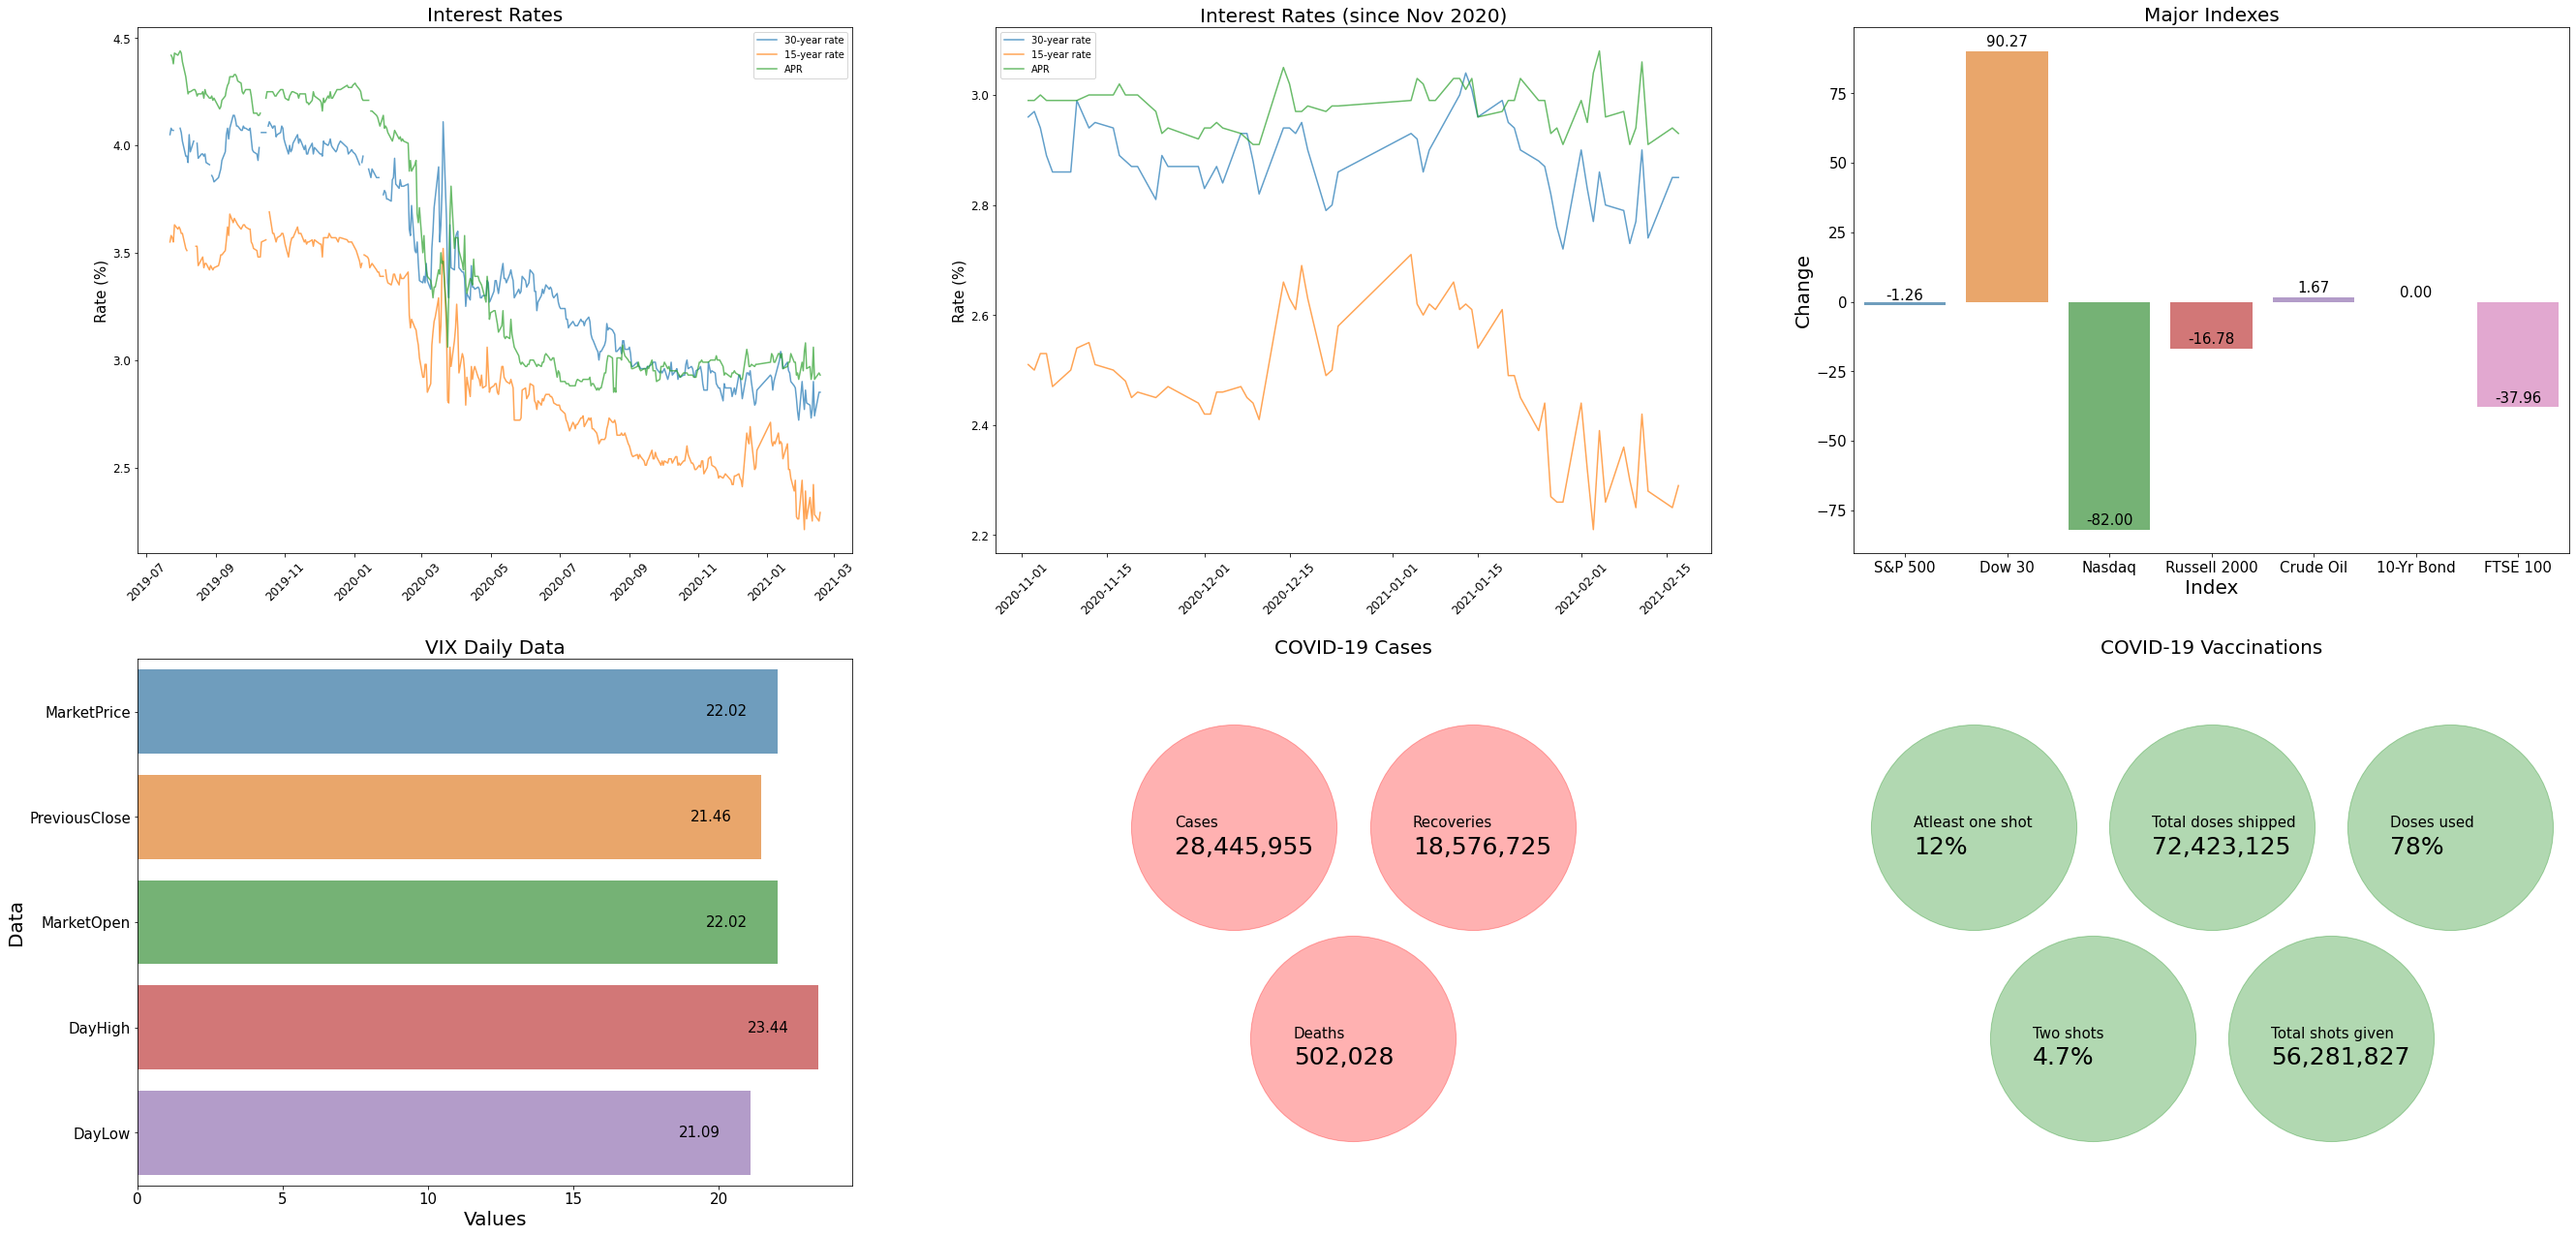

In [164]:
plt.figure(figsize=(45,22))

plt.subplot(2,3,1)
plt.plot(int_rates['30-year rate'],label=int_rates.columns[1],alpha=0.7)
plt.plot(int_rates['15-year rate'],label=int_rates.columns[2],alpha=0.7)
plt.plot(int_rates['APR'],label=int_rates.columns[3],alpha=0.7)
plt.xticks(rotation=45,size=12)
plt.yticks(size=12)
plt.ylabel('Rate (%)',size=15)
plt.title('Interest Rates',size=20)
#plt.axis('off')
plt.legend()

int_rates_red = int_rates.iloc[int_rates.index > '11-2020']
plt.subplot(2,3,2)
plt.plot(int_rates_red['30-year rate'],label=int_rates_red.columns[1],alpha=0.7)
plt.plot(int_rates_red['15-year rate'],label=int_rates_red.columns[2],alpha=0.7)
plt.plot(int_rates_red['APR'],label=int_rates_red.columns[3],alpha=0.7)
plt.xticks(rotation=45,size=12)
plt.yticks(size=12)
plt.ylabel('Rate (%)',size=15)
plt.title('Interest Rates (since Nov 2020)',size=20)
#plt.axis('off')
plt.legend()

'''
r1 = range(indexes.shape[0]) 
r2 = [x + 0.25 for x in r1]
r1 = [x - 0.25 for x in r1]
colors = ['orange','green','brown','purple','red','blue','yellow']
plt.subplot(2,3,3)
plt.bar(r1,indexes['Change'],0.45,alpha=0.4,label='Value change',color=colors)
plt.yticks(size=16)
plt.ylabel('Change (%)',size=15)
plt.xticks(range(indexes.shape[0]),indexes.index,size=12,rotation=45)
#plt.axis('off')
plt.legend()
'''

vix_data = {"MarketPrice":vix.info['regularMarketPrice'],"PreviousClose":vix.info['regularMarketPreviousClose'],"MarketOpen":vix.info['regularMarketOpen'],"DayHigh":vix.info['dayHigh'],"DayLow":vix.info['dayLow']}
plt.subplot(2,3,3)
plots = sns.barplot(y="Change", x="Index", data=indexes,alpha=0.7) 
  
# Iterrating over the bars one-by-one 
for bar in plots.patches: 
  # Using Matplotlib's annotate function and 
  # passing the coordinates where the annotation shall be done 
  # x-coordinate: bar.get_x() + bar.get_width() / 2 
  # y-coordinate: bar.get_height() 
  # free space to be left to make graph pleasing: (0, 8) 
  # ha and va stand for the horizontal and vertical alignment 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,bar.get_height()+0.6), ha='center', va='center', 
                   size=15, xytext=(0,8), 
                   textcoords='offset points')  
plt.xlabel('Index',size=20)
plt.ylabel('Change',size=20)
plt.title('Major Indexes',size=20)
plt.xticks(size=15)
plt.yticks(size=15)

vix_data = {"MarketPrice":vix.info['regularMarketPrice'],"PreviousClose":vix.info['regularMarketPreviousClose'],"MarketOpen":vix.info['regularMarketOpen'],"DayHigh":vix.info['dayHigh'],"DayLow":vix.info['dayLow']}

df_vix = pd.DataFrame()
df_vix['Stat'] = list(vix_data.keys())
df_vix['Value'] = list(vix_data.values())

plt.subplot(2,3,4)
plots = sns.barplot(y="Stat", x="Value", data=df_vix,alpha=0.7) 
  
# Iterrating over the bars one-by-one 
for bar in plots.patches: 
  # Using Matplotlib's annotate function and 
  # passing the coordinates where the annotation shall be done 
  # x-coordinate: bar.get_x() + bar.get_width() / 2 
  # y-coordinate: bar.get_height() 
  # free space to be left to make graph pleasing: (0, 8) 
  # ha and va stand for the horizontal and vertical alignment 
    plots.annotate(format(bar.get_width(), '.2f'),  
                   (bar.get_width()-2,bar.get_y() + bar.get_height() / 2), ha='center', va='center', 
                   size=15, xytext=(8,0), 
                   textcoords='offset points')  
plt.xlabel('Values',size=20)
plt.ylabel('Data',size=20)
plt.title('VIX Daily Data',size=20)
plt.xticks(size=15)
plt.yticks(size=15)

plt.subplot(2,3,5)
x = [2,3,4]
y = [18,-22,18]
c = ['blue','red','blue']
count = 0
plt.scatter(x,y,s=45000,alpha=0.3,c='red')
for i,j in zip(x,y):
  plt.annotate(list(cases.keys())[count],xy=(i-0.5,j),size=15)
  plt.annotate(list(cases.values())[count],xy=(i-0.5,j-5),size=25)
  count = count + 1
plt.axis('off')
plt.xlim(0,6)
plt.ylim(-50,50)
plt.title('COVID-19 Cases',size=20)

plt.subplot(2,3,6)
x = [1,2,3,4,5]
y = [18,-22,18,-22,18]
c = ['blue','red','blue','red','blue']
count = 0
plt.scatter(x,y,s=45000,alpha=0.3,c='green')
for i,j in zip(x,y):
  plt.annotate(list(vac_labels.keys())[count],xy=(i-0.5,j),size=15)
  plt.annotate(vac_values[count],xy=(i-0.5,j-5),size=25)
  count = count + 1
plt.axis('off')
plt.xlim(0,6)
plt.ylim(-50,50)
plt.title('COVID-19 Vaccinations',size=20)

